# Notebook 1 - Wavelets and Frequency Information

https://pywavelets.readthedocs.io/en/latest/ref/index.html

## Section 0 - Import libraries, and load metadata and beats

In [1]:
from multiprocessing import Pool, cpu_count
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import convolve
from sklearn import svm, neighbors
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import pywt
import wfdb

from bc.beats import get_beats, get_beat_bank, BEAT_TYPES
from bc.io import ann_to_df
from bc.plot import plot_beat, plot_four_beats

base_dir = os.path.abspath('..')
data_dir = os.path.join(base_dir, 'data')

# Table of record names and the beat types they contain
beat_table = pd.read_csv(os.path.join(data_dir, 'beat-types.csv'), dtype={'record':object})
beat_table.set_index('record', inplace=True)

fs = 360
sampling_period = 1/fs

In [3]:
# Load Beats, applying the standard ecg bandpass filter
n_beats, n_centers = get_beat_bank(data_dir=data_dir, beat_table=beat_table,
                                   wanted_type='N', filter_beats=True, fixed_width=240)
l_beats, l_centers = get_beat_bank(data_dir=data_dir, beat_table=beat_table,
                                   wanted_type='L' ,filter_beats=True, fixed_width=240)
r_beats, r_centers = get_beat_bank(data_dir=data_dir, beat_table=beat_table,
                                   wanted_type='R', filter_beats=True, fixed_width=240)
v_beats, v_centers = get_beat_bank(data_dir=data_dir, beat_table=beat_table,
                                   wanted_type='V', filter_beats=True, fixed_width=240)

sample_beats = [n_beats[0], l_beats[0], r_beats[0], v_beats[0]]

## Section 1 - Explore Wavelets

We are using the `pywt` library. Explore the abailable wavelet families and wavelets.

We have 3 tasks for our continuous wavelet transform:
1. Choose wavelet types that will discern the different beats
2. Choose scales to match the features

In [5]:
# All wavelet families
print(pywt.families(), '\n')
# All wavelets
print(pywt.wavelist(), '\n')
# All wavelets of a particular family
print(pywt.wavelist(family='bior'), '\n')
# Continuous wavelets
print(pywt.wavelist(kind='continuous'), '\n')

['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'] 

['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'haar', 'mexh', 'morl', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8

/home/cx1111/Software/python-envs/p35/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cx1111/Software/python-envs/p35/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: Wavelets of family fbsp, without parameters specified in the name are deprecated.  The name should take the form fbspM-B-C where M is the spline order and B, C are floats representing the bandwidth frequency and center frequency, respectively (example: fbsp1-1.5-1.0).
  This is separate from the ipykernel package so we can avoid doing imports until


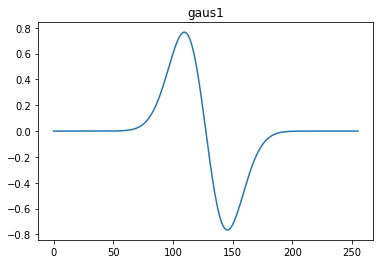

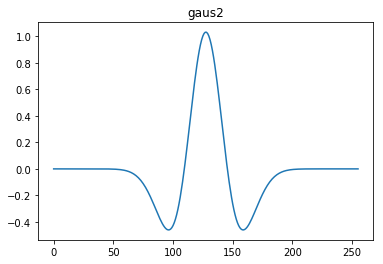

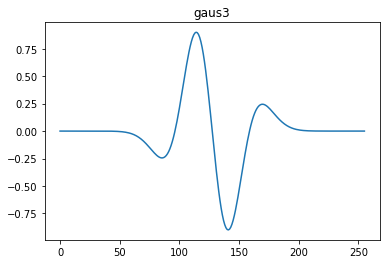

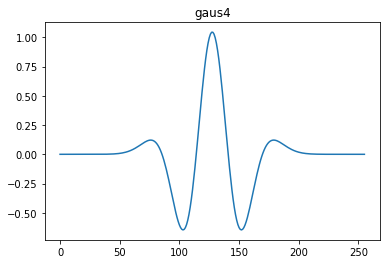

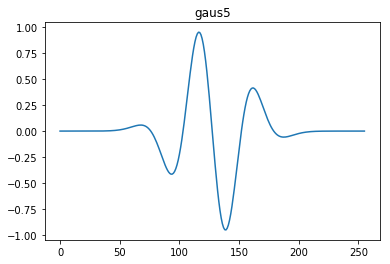

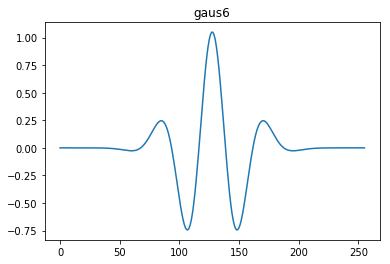

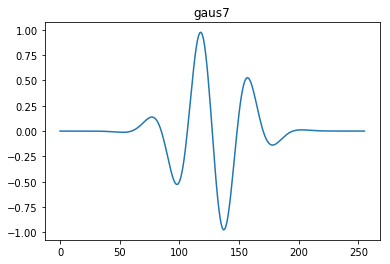

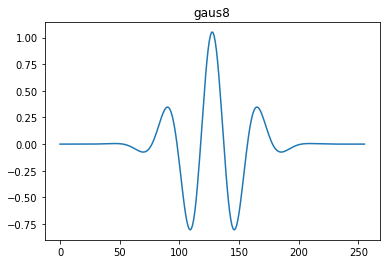

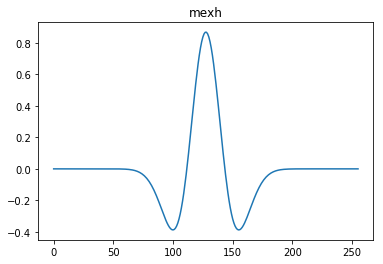

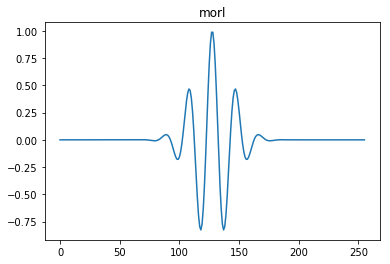

/home/cx1111/Software/python-envs/p35/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: Wavelets from the family shan, without parameters specified in the name are deprecated. The name should takethe form shanB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: shan1.5-1.0).
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
# Plot the continuous wavelet family functions, excluding complex values ones
for family in pywt.wavelist(kind='continuous'):
    wavelet = pywt.ContinuousWavelet(family)
    if not wavelet.complex_cwt:
        plt.plot(wavelet.wavefun()[0])
        plt.title(family)
        plt.show()

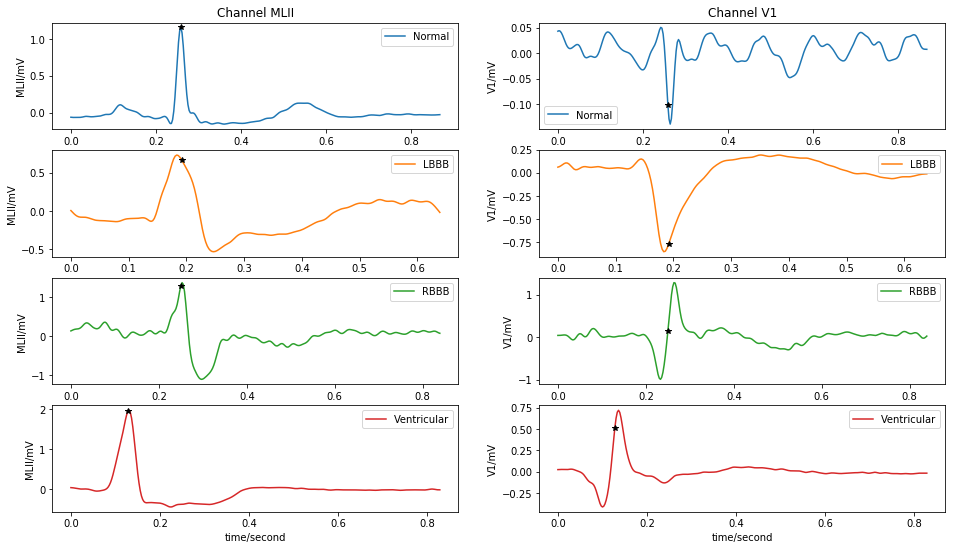

In [49]:
# Visualize one of each beat type to compare with wavelets
plot_four_beats(beats=[n_beats[0], l_beats[0], r_beats[0], v_beats[0]],
                centers=[n_centers[0], l_centers[0], r_centers[0], v_centers[0]])

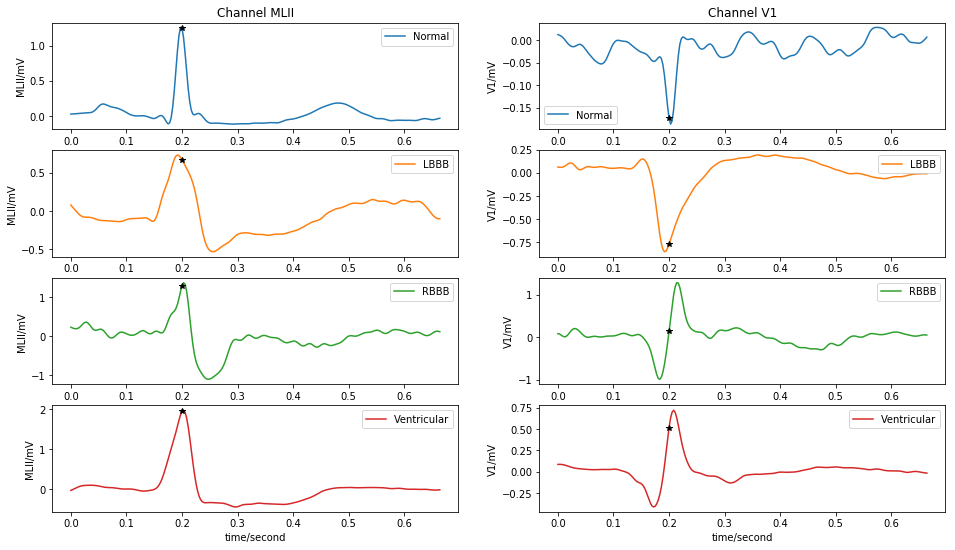

In [5]:
# Visualize one of each beat type to compare with wavelets
plot_four_beats(beats=[n_beats[0], l_beats[0], r_beats[0], v_beats[0]],
                centers=[n_centers[0], l_centers[0], r_centers[0], v_centers[0]])

### Question 1: Which wavelets should be used for the continuous wavelet transform?

We will use them to detect the ECG morphologies. It will be most effective to choose ones that are shaped similarly to the various ECG segments.

In [ ]:
# In this exercise, we will select Gaus1 and Gaus2.

### Question 2: Which scales should we use for the continuous wavelet transform?

We want wavelet scales that capture patterns of the relevant frequencies.

In [180]:
# Regular qrs width is about 0.05s = 0.05 * 360 = 18 samples
# A period of 0.05s corresponds to 1/.05 = 20Hz

# help(pywt.scale2frequency)
scale = 1
sampling_period = 1 / 360
for scale in [2,4,8,16,32,64]:
    f = pywt.scale2frequency(wavelet='gaus1', scale=scale)/sampling_period
    print('Level: {}, Frequency: {}'.format(scale, f))

Level: 2, Frequency: 36.0
Level: 4, Frequency: 18.0
Level: 8, Frequency: 9.0
Level: 16, Frequency: 4.5
Level: 32, Frequency: 2.25
Level: 64, Frequency: 1.125


In [21]:
print(freqs)
print(coef.shape)

[54.    27.    13.5    6.75   3.375]
(5, 299)


In [19]:
coef, freqs = pywt.cwt(data=sample_beats[2][:, 1], scales=[2,4,8,16,32], wavelet=w,
                       sampling_period=sampling_period)

NameError: name 'sample_beats' is not defined

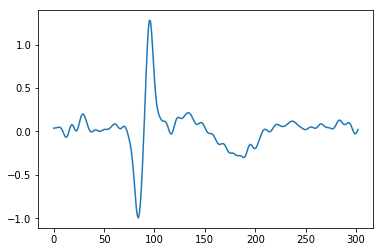

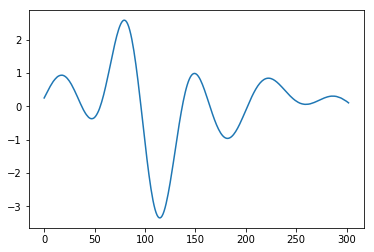

In [192]:
plt.figure()
plt.plot(sample_beats[2][:,1])
plt.show()

plt.figure()
plt.plot(coef[-1])
plt.show()

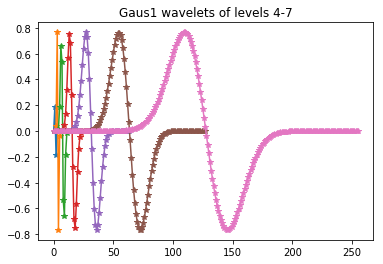

In [101]:
wavelet = pywt.ContinuousWavelet('gaus1')
for level in [2, 3, 4, 5, 6, 7, 8]:
    plt.plot(wavelet.wavefun(level=level)[0], '*-')
    plt.title('Gaus1 wavelets of levels 4-7')
plt.show()

In [ ]:
help(wavelet.wavefun)

In [21]:
help(pywt.cwt)

Help on function cwt in module pywt._cwt:

cwt(data, scales, wavelet, sampling_period=1.0)
    cwt(data, scales, wavelet)
    
    One dimensional Continuous Wavelet Transform.
    
    Parameters
    ----------
    data : array_like
        Input signal
    scales : array_like
        The wavelet scales to use. One can use
        ``f = scale2frequency(scale, wavelet)/sampling_period`` to determine
        what physical frequency, ``f``. Here, ``f`` is in hertz when the
        ``sampling_period`` is given in seconds.
    wavelet : Wavelet object or name
        Wavelet to use
    sampling_period : float
        Sampling period for the frequencies output (optional).
        The values computed for ``coefs`` are independent of the choice of
        ``sampling_period`` (i.e. ``scales`` is not scaled by the sampling
        period).
    
    Returns
    -------
    coefs : array_like
        Continuous wavelet transform of the input signal for the given scales
        and wavelet
    fre

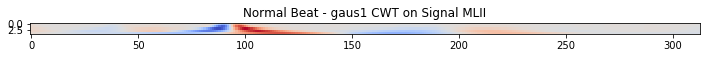

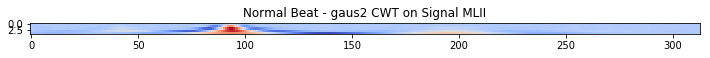

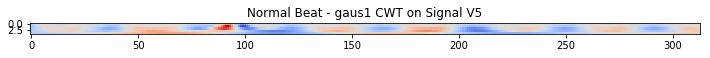

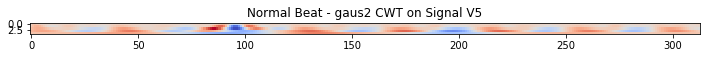

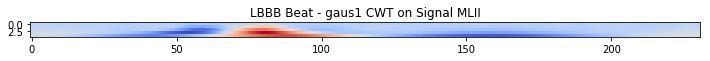

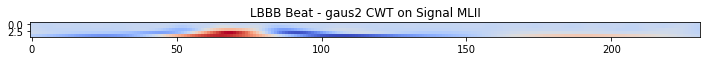

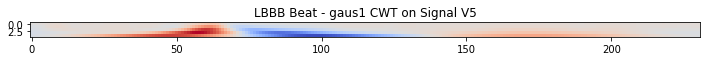

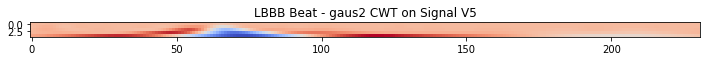

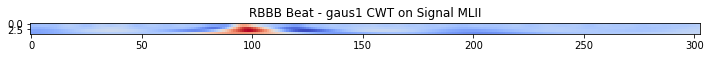

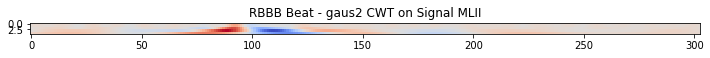

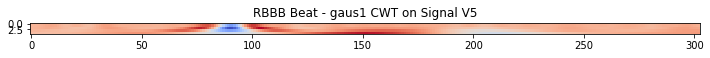

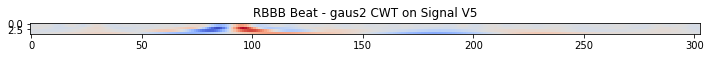

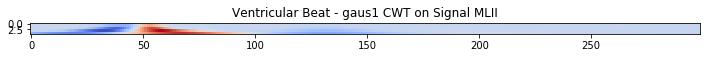

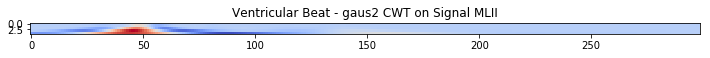

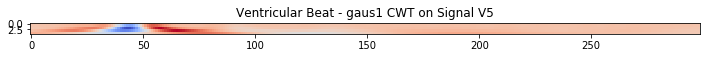

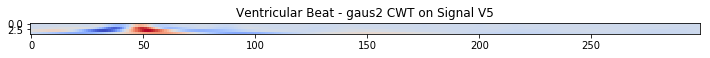

In [20]:
# Show output of continuous wavelet transform with two wavelet types, on both channels.
sig_names = ['MLII', 'V5']
wavelet_types = ['gaus1', 'gaus2']
sample_beats = [n_beats[0], l_beats[0], r_beats[0], v_beats[0]]

for beat_num in range(len(BEAT_TYPES)):
    for sig_num in range(len(sig_names)):
        for w in wavelet_types:
            coef, freqs = pywt.cwt(data=sample_beats[beat_num][:, sig_num], scales=[2,4,8,16,32], wavelet=w,
                                   sampling_period=sampling_period)
            plt.figure(figsize=(12, 9))
            plt.title('{} Beat - {} CWT on Signal {}'.format(BEAT_TYPES[beat_num], w, sig_names[sig_num]))
            plt.imshow(coef, cmap='coolwarm')
            plt.show()

In [117]:
w1 = wavelet.wavefun(level=1)[0]
w2 = wavelet.wavefun(level=2)[0]

In [153]:
help(wavelet.wavefun)

Help on built-in function wavefun:

wavefun(...) method of pywt._extensions._pywt.ContinuousWavelet instance
    wavefun(self, level=8, length=None)
    
    Calculates approximations of wavelet function (``psi``) on xgrid
    (``x``) at a given level of refinement or length itself.
    
    Parameters
    ----------
    level : int, optional
        Level of refinement (default: 8). Defines the length by
        ``2**level`` if length is not set.
    length : int, optional
        Number of samples. If set to None, the length is set to
        ``2**level`` instead.
    
    Returns
    -------
    psi : array_like
        Wavelet function computed for grid xval
    xval : array_like
        grid going from lower_bound to upper_bound
    
    Notes
    -----
    The effective support are set with ``lower_bound`` and ``upper_bound``.
    The wavelet function is complex for ``'cmor'``, ``'shan'``, ``'fbsp'``
    and ``'cgau'``.
    
    The complex frequency B-spline wavelet (``'fbsp'``)

In [176]:
wavelet.short_family_name

'gaus'

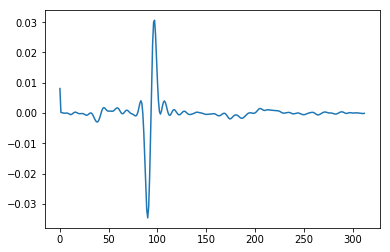

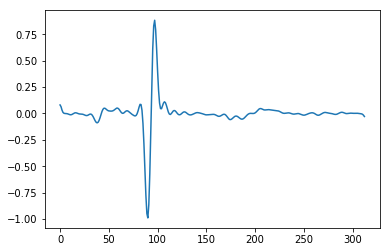

In [172]:
l = 2
result = convolve(n_beats[0][:, 0], np.conj(wavelet.wavefun(level=l)[0]), mode='same') / l**0.5

plt.figure()
plt.plot(-result)
plt.show()

plt.figure()
plt.plot(coef[1,:])
plt.show()


In [163]:
coef, freqs = pywt.cwt(data=n_beats[0][:, 0], scales=np.arange(1,10), wavelet='gaus1',
                                   sampling_period=sampling_period)

In [ ]:
wavelet.wavefun(level=1)

In [116]:
np.sum(np.abs(coef), axis=-1)
    

array([   5.92079455,   15.51346673,   25.74336909,   35.4546409 ,
         44.86515523,   54.03386884,   62.72806088,   70.9923734 ,
         78.88474186,   86.21564662,   92.96618628,   99.10061385,
        104.70783296,  109.59310053,  113.93511836,  117.58684887,
        120.83538373,  123.4869776 ,  125.76812351,  127.69871017,
        129.34746507,  130.74595482,  132.15897485,  133.72847153,
        135.57071076,  137.05054338,  138.22949568,  139.18195458,
        139.86761654,  140.32073237,  140.52022891,  140.46858621,
        140.26395818,  139.66343367,  139.18582804,  138.36952422,
        137.3419674 ,  136.1856973 ,  134.90080437,  133.37618675,
        131.90965466,  130.00434136,  128.08751513,  126.1660018 ,
        124.02247716,  121.99615568,  119.74757539,  117.44785048,
        115.26030533,  112.60216733,  109.84112355,  107.84142889,
        105.27480798,  102.89887557,  100.36976582,   97.79941328,
         95.35647598,   92.82213946,   90.45389784,   87.81363

In [122]:
coef.shape

(79, 313)

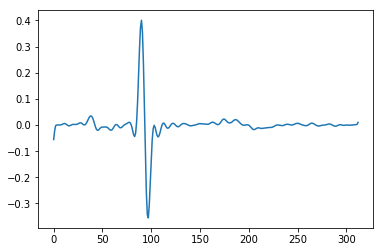

In [124]:
plt.figure()
plt.plot(-coef[0,:])
plt.show()

In [79]:
help(convolve)

Help on function convolve in module scipy.signal.signaltools:

convolve(in1, in2, mode='full', method='auto')
    Convolve two N-dimensional arrays.
    
    Convolve `in1` and `in2`, with the output size determined by the
    `mode` argument.
    
    Parameters
    ----------
    in1 : array_like
        First input.
    in2 : array_like
        Second input. Should have the same number of dimensions as `in1`.
    mode : str {'full', 'valid', 'same'}, optional
        A string indicating the size of the output:
    
        ``full``
           The output is the full discrete linear convolution
           of the inputs. (Default)
        ``valid``
           The output consists only of those elements that do not
           rely on the zero-padding. In 'valid' mode, either `in1` or `in2`
           must be at least as large as the other in every dimension.
        ``same``
           The output is the same size as `in1`, centered
           with respect to the 'full' output.
    method

In [ ]:
coef.shape

In [ ]:
freqs

In [ ]:
n_features = n_per_image * n_sig * n_wavelet_types


In [43]:
len(v_beats)

7029

In [ ]:

plt.figure()
for scalenum in range(coef.shape[0]):
    plt.plot(coef[scalenum, :])
    
plt.legend([str(s) for s in range(1, 30)])
plt.show()

In [ ]:
# RBBB gaus1
coef, freqs = pywt.cwt(r_beats[0][:, 0], np.arange(1,30), 'gaus1', sampling_period=1/360, )
plt.figure(figsize=(12, 9))
plt.imshow(coef, cmap='coolwarm')
plt.show()

In [ ]:
# RBBB gaus2
coef, freqs = pywt.cwt(r_beats[0][:, 0], np.arange(1,30), 'gaus2', sampling_period=1/360, )
plt.figure(figsize=(12, 9))
plt.imshow(coef, cmap='coolwarm')
plt.show()

## Section 2 - Building Features

In [14]:
# For each beat, we want a set of features to feed into a classifier
# Each beat will have two wavelet families tested on its two channels.
# We will get the maximum convolution value and the level at which it occurs.
feature_names = ['gaus1_max_II', 'gaus1_max_scale_II', 'gaus2_max_II', 'gaus2_max_scale_II',
            'gaus1_max_V', 'gaus1_max_scale_V', 'gaus2_max_V', 'gaus2_max_scale_V']



In [7]:
n_features = pd.DataFrame(columns=feature_names)

In [17]:
def calc_wavelet_features(beat):
    """
    Calculate the 8 features for the 2 channel beat
    """
    scales = np.arange(1, 30)
    sig_name = ['MLII', 'V1']
    features = []
    
    for ch in range(2):
        # Reverse channel V1 for qrs complexes to match gaus1 wavelet deflection
        # Q: Why does this time domain reversal not affect our feature?
        if ch == 1:
            sig = - beat[:, ch]
            #sig = beat[::-1, ch]
        else:
            sig = beat[:, ch]
            
        for wavefun in ['gaus1', 'gaus2']:
            # Calculate continuous wavelet transform
            coef, freqs = pywt.cwt(sig, np.arange(1,30), wavefun, sampling_period=1/360)
            # The maximum value of the convolution array
            max_coef = coef.max()
            # The scale at which the maximum convolution value occurs
            max_scale = scales[np.where(coef==max_coef)[0][0]]
            # Save the features
            features += [max_coef, max_scale]
    return features
    

def calc_better_wavelet_features(beat):
    """
    Calculate the features for the 2 channel beat
    """
    scales = np.arange(1, 30)
    sig_name = ['MLII', 'V1']
    features = []
    
    for ch in range(2):
        # Reverse channel V1 for qrs complexes to match gaus1 wavelet deflection
        # Q: Why does this time domain reversal not affect our feature?
        if ch == 1:
            sig = -beat[:, ch]
        else:
            sig = beat[:, ch]
            
        for wavefun in ['gaus1', 'gaus2']:
            # Calculate continuous wavelet transform
            coef, freqs = pywt.cwt(sig, np.arange(1,30), wavefun, sampling_period=1/360)
            # The maximum value of the convolution array
            max_coef = np.max(coef, axis=1)
            max_loc = np.argmax(coef, axis=1)
            
            for scalenum in range(coef.shape[0]):
                features += [max_coef[scalenum], max_loc[scalenum]]
    return features
    

In [11]:
# Try on some beats
for beat_num in range(len(BEAT_TYPES)):
    features = calc_wavelet_features(sample_beats[beat_num])
    print(BEAT_TYPES[beat_num], features)

Normal [2.035197961951487, 10, 2.4839493857917017, 9, 0.30902530117709376, 7, 0.30614808975696295, 8]
LBBB [3.293157560444452, 17, 3.1758389631177186, 21, 2.4496005845082465, 29, 2.716404379758544, 29]
RBBB [5.370461911219034, 13, 4.275797478152503, 14, 4.004004623954681, 8, 3.312797368287868, 11]
Ventricular [5.519782733237216, 18, 5.772623742374277, 19, 2.143489402343681, 9, 1.6336356026826226, 12]


## Section 3 - Calculate wavelet features and classify

In [12]:
# Get all the beats and labels together
all_beats = n_beats + l_beats + r_beats + v_beats
labels = [0]*len(n_beats) + [1]*len(l_beats) + [2]*len(r_beats) + [3]*len(v_beats)

In [15]:
# Calculate features for all records using multiple cpus
pool = Pool(processes=cpu_count() - 1)
features = pool.map(calc_wavelet_features, all_beats)

# Combine features into a data frame
features = pd.DataFrame(features, columns=feature_names)
features['type'] = labels

In [19]:
# Better features

# Calculate features for all records using multiple cpus
pool = Pool(processes=cpu_count() - 1)
features = pool.map(calc_better_wavelet_features, all_beats)

# Combine features into a data frame
features = pd.DataFrame(features)
features['type'] = labels

In [18]:
# Question: How many rows and columns should the feature matrix have?
features.head()

,gaus1_max_II,gaus1_max_scale_II,gaus2_max_II,gaus2_max_scale_II,gaus1_max_V,gaus1_max_scale_V,gaus2_max_V,gaus2_max_scale_V,type
0,2.035198,10,2.483949,9,0.309025,7,0.306148,8,0
1,1.962847,10,2.385450,10,0.219624,4,0.287841,6,0
2,2.209377,10,2.687312,11,0.270682,12,0.310593,13,0
3,2.239574,10,2.787396,11,0.230859,6,0.217360,7,0
4,2.352299,9,2.861453,10,0.222073,14,0.266714,16,0


In [ ]:
# Visualize some results so that we can see if there is any inter-group difference

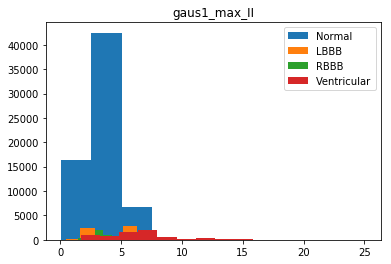

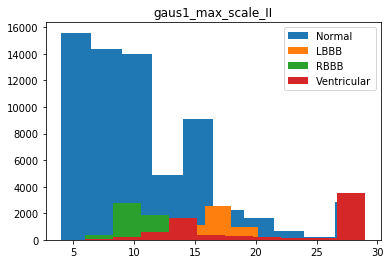

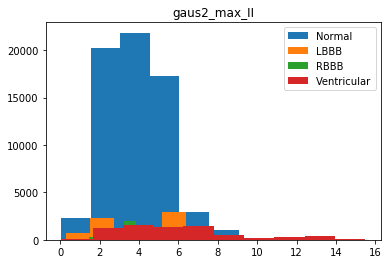

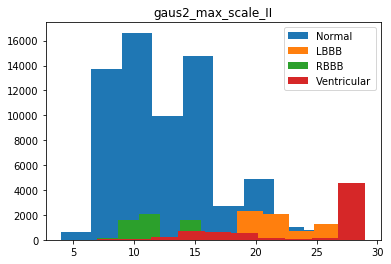

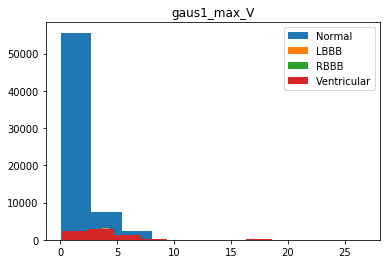

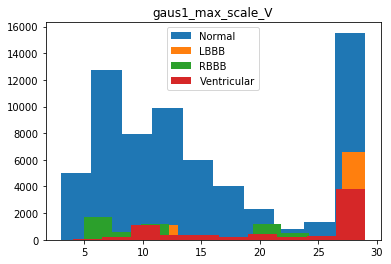

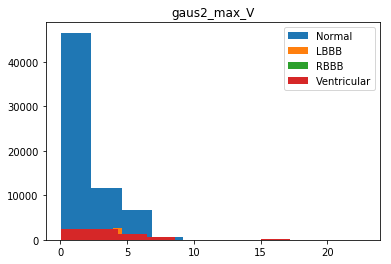

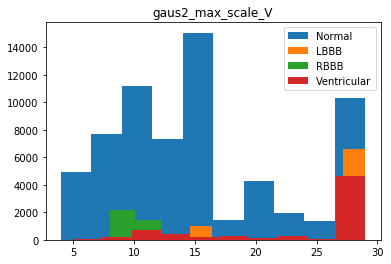

In [14]:
# Recall the features
# feature_names = ['gaus1_max_II', 'gaus1_max_scale_II', 'gaus2_max_II', 'gaus2_max_scale_II',
#            'gaus1_max_V', 'gaus1_max_scale_V', 'gaus2_max_V', 'gaus2_max_scale_V']

# Show some features
for f in feature_names:
    plt.figure()
    for groupnum in range(4):
        plt.hist(features.loc[np.equal(labels, groupnum), f])
    plt.title(f)
    plt.legend(BEAT_TYPES)
    plt.show()
    
# Question: Which features do you think will be more useful?
# Gaus1 is the sinusoud, gaus2 is the hat.


In [20]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(features, labels,
                                                    train_size=0.75, test_size=0.25,
                                                    random_state=0)
print('Number of training records: %d' % len(x_train))
print('Number of testing records: %d' % len(x_test))

Number of training records: 64803
Number of testing records: 21602


In [ ]:
# LR
clf_lr = LogisticRegression()
clf_lr.fit(x_train, y_train)
y_predict_lr = clf_lr.predict(x_test)

# KNN
clf_knn = neighbors.KNeighborsClassifier()
clf_knn.fit(x_train, y_train)
y_predict_knn = clf_knn.predict(x_test)

# SVM
clf_svm = svm.SVC()
clf_svm.fit(x_train, y_train)
y_predict_svm = clf_svm.predict(x_test)

# And GB
clf_gb = GradientBoostingClassifier()
clf_gb.fit(x_train, y_train)
y_predict_gb = clf_gb.predict(x_test)

In [17]:
print('Logistic Regression')
print(classification_report(y_test, y_predict_lr, target_names=BEAT_TYPES))

print('K Nearest Neigbors')
print(classification_report(y_test, y_predict_knn, target_names=BEAT_TYPES))

print('Support Vector Machines')
print(classification_report(y_test, y_predict_svm, target_names=BEAT_TYPES))

print('Gradient Boosting')
print(classification_report(y_test, y_predict_gb, target_names=BEAT_TYPES))


Logistic Regression
             precision    recall  f1-score   support

     Normal       1.00      1.00      1.00     16438
       LBBB       1.00      1.00      1.00      1971
       RBBB       0.96      1.00      0.98      1464
Ventricular       1.00      0.97      0.98      1726

avg / total       1.00      1.00      1.00     21599

K Nearest Neigbors
             precision    recall  f1-score   support

     Normal       1.00      1.00      1.00     16438
       LBBB       0.99      0.99      0.99      1971
       RBBB       0.99      1.00      0.99      1464
Ventricular       0.99      0.98      0.98      1726

avg / total       1.00      1.00      1.00     21599

Support Vector Machines
             precision    recall  f1-score   support

     Normal       1.00      1.00      1.00     16438
       LBBB       1.00      0.99      0.99      1971
       RBBB       1.00      1.00      1.00      1464
Ventricular       1.00      0.97      0.99      1726

avg / total       1.00      

In [ ]:
print('Logistic Regression')
print(classification_report(y_test, y_predict_lr, target_names=BEAT_TYPES))

print('K Nearest Neigbors')
print(classification_report(y_test, y_predict_knn, target_names=BEAT_TYPES))

print('Support Vector Machines')
print(classification_report(y_test, y_predict_svm, target_names=BEAT_TYPES))

print('Gradient Boosting')
print(classification_report(y_test, y_predict_gb, target_names=BEAT_TYPES))


In [ ]:
# 360 * .2 = 72 samples in 0.2s.
# 40hz signal = 360 / 40 = 9 samples.

widths = np.arange(6, 73, 6)
cwtmatr = cwt(data=n_beats[0][:,0], wavelet=ricker, widths=widths)
plt.figure(figsize=(6.4, 4.8))
plt.imshow(cwtmatr, extent=[0, n_beats[0].shape[0], 72, 6], cmap='coolwarm', aspect='auto',
         vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())

plot_beat(n_beats[0], n_centers[0], style='C0', title='Normal Beat')

cwtmatr = cwt(data=-n_beats[0][:,1], wavelet=ricker, widths=widths)
plt.figure(figsize=(6.4, 4.8))
plt.imshow(cwtmatr, extent=[0, n_beats[0].shape[0], 72, 6], cmap='coolwarm', aspect='auto',
         vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())

cwtmatr = cwt(data=v_beats[0][:,0], wavelet=ricker, widths=widths)
plt.figure(figsize=(6.4, 4.8))
plt.imshow(cwtmatr, extent=[0, v_beats[0].shape[0], 72, 6], cmap='coolwarm', aspect='auto',
         vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())